In [1]:
import pandas as pd
import numpy as np
# import pinball loss from sklearn
from sklearn.metrics import mean_pinball_loss

In [2]:
# load csv file
df = pd.read_csv('wp_forecasters_comparison_results_no_mostrecent.csv')
print(df.shape)

# min and max values for datetime
min_date = df['datetime'].min()
max_date = df['datetime'].max()
print('Min date:', min_date)
print('Max date:', max_date)

df_clean = df.rename(columns={'10_predictions': 'q10_QRA', '50_predictions': 'q50_QRA', '90_predictions': 'q90_QRA'})
df_clean.head()

(104544, 29)
Min date: 2021-02-01 00:00:00+00:00
Max date: 2024-01-25 23:45:00+00:00


,datetime,measured,mostrecentforecast,dayahead11hforecast,dayaheadforecast,weekaheadforecast,mostrecentconfidence10,dayahead11hconfidence10,dayaheadconfidence10,weekaheadconfidence10,...,q90_best_model,q10_weight_avg,q50_weight_avg,q90_weight_avg,q10_weight_avg_soft,q50_weight_avg_soft,q90_weight_avg_soft,q10_equal_weights,q50_equal_weights,q90_equal_weights
0,2021-02-01 00:00:00+00:00,359.51,711.61,1256.36,1292.65,1571.94,400.20,516.02,539.30,109.03,...,1359.73,444.392827,1352.584368,1566.818501,538.891822,1260.527311,1359.774759,391.1375,1208.1400,1456.5850
1,2021-02-01 00:15:00+00:00,337.28,683.16,1210.05,1229.97,1547.77,374.69,485.48,544.80,108.99,...,1352.21,434.802995,1306.129418,1538.533937,543.759918,1212.337485,1352.200780,378.4900,1167.7375,1425.7900
2,2021-02-01 00:30:00+00:00,331.07,642.53,1185.44,1164.05,1578.32,342.66,464.40,508.39,110.05,...,1310.84,411.819638,1280.966725,1515.571899,507.618705,1182.983710,1310.851755,356.3750,1142.5850,1401.9775
3,2021-02-01 00:45:00+00:00,313.61,596.20,1190.46,1113.09,1633.52,314.97,458.53,483.93,119.24,...,1281.50,401.288815,1278.776463,1503.835143,483.484651,1181.575325,1281.537532,344.1675,1133.3175,1383.1150
4,2021-02-01 01:00:00+00:00,317.85,553.78,1199.45,1061.04,1658.29,291.81,458.11,463.19,143.16,...,1249.97,397.346659,1269.664677,1491.758570,463.100930,1183.555883,1250.036519,339.0675,1118.1400,1366.9300


In [3]:
# join the two dataframes
df = df_clean.copy() #.set_index('datetime').join(df_stack_clean.set_index('datetime')[['q10_stack', 'q50_stack', 'q90_stack']], on='datetime').reset_index()
# add date column
df['date'] = pd.to_datetime(df['datetime']).dt.date
# add month-year column
df['month_year'] = pd.to_datetime(df['datetime']).dt.to_period('M')
df.head()

/var/folders/k7/l3pjpdtn7fg19hrh291yqwjw0000gn/T/ipykernel_37220/2449334271.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = pd.to_datetime(df['datetime']).dt.to_period('M')


,datetime,measured,mostrecentforecast,dayahead11hforecast,dayaheadforecast,weekaheadforecast,mostrecentconfidence10,dayahead11hconfidence10,dayaheadconfidence10,weekaheadconfidence10,...,q50_weight_avg,q90_weight_avg,q10_weight_avg_soft,q50_weight_avg_soft,q90_weight_avg_soft,q10_equal_weights,q50_equal_weights,q90_equal_weights,date,month_year
0,2021-02-01 00:00:00+00:00,359.51,711.61,1256.36,1292.65,1571.94,400.20,516.02,539.30,109.03,...,1352.584368,1566.818501,538.891822,1260.527311,1359.774759,391.1375,1208.1400,1456.5850,2021-02-01,2021-02
1,2021-02-01 00:15:00+00:00,337.28,683.16,1210.05,1229.97,1547.77,374.69,485.48,544.80,108.99,...,1306.129418,1538.533937,543.759918,1212.337485,1352.200780,378.4900,1167.7375,1425.7900,2021-02-01,2021-02
2,2021-02-01 00:30:00+00:00,331.07,642.53,1185.44,1164.05,1578.32,342.66,464.40,508.39,110.05,...,1280.966725,1515.571899,507.618705,1182.983710,1310.851755,356.3750,1142.5850,1401.9775,2021-02-01,2021-02
3,2021-02-01 00:45:00+00:00,313.61,596.20,1190.46,1113.09,1633.52,314.97,458.53,483.93,119.24,...,1278.776463,1503.835143,483.484651,1181.575325,1281.537532,344.1675,1133.3175,1383.1150,2021-02-01,2021-02
4,2021-02-01 01:00:00+00:00,317.85,553.78,1199.45,1061.04,1658.29,291.81,458.11,463.19,143.16,...,1269.664677,1491.758570,463.100930,1183.555883,1250.036519,339.0675,1118.1400,1366.9300,2021-02-01,2021-02


In [4]:
# calculate rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# calculate mean pinball loss with sklearn
def mean_pinball_loss_sklearn(targets, predictions, tau):
    return mean_pinball_loss(targets, predictions, alpha=tau)

In [5]:
def compute_rmse_testing_days(df, predictions, targets = 'measured', date_column = 'date'):
    " Compute RMSE for each day in the dataframe "
    rmse_list = []
    for date in df[date_column].unique():
        date_df = df[df[date_column] == date]
        rmse_list.append(rmse(date_df[targets], date_df[predictions]))
    return rmse_list

def compute_pinball_loss_testing_days(df, tau, predictions, targets = 'measured', date_column = 'date'):
    " Compute Pinball Loss for each day in the dataframe "
    pinball_loss_list = []
    for date in df[date_column].unique():
        date_df = df[df[date_column] == date]
        pinball_loss_list.append(mean_pinball_loss_sklearn(date_df[targets], date_df[predictions], tau))
    return pinball_loss_list

def compute_coverage_testing_days(df, predictions_q10, predictions_q90, targets = 'measured', date_column = 'date'):
    " Compute coverage for each day in the dataframe "
    coverage_list = []
    for date in df[date_column].unique():
        date_df = df[df[date_column] == date]
        coverage_list.append(np.mean((date_df[predictions_q10] <= date_df[targets]) & (date_df[predictions_q90] >= date_df[targets])))
    return coverage_list

def compute_sharpness_testing_days(df, predictions_q10, predictions_q90, date_column = 'date'):
    " Compute sharpness for each day in the dataframe "
    sharpness_list = []
    for date in df[date_column].unique():
        date_df = df[df[date_column] == date]
        sharpness_list.append(np.mean(date_df[predictions_q90] - date_df[predictions_q10]))
    return sharpness_list

In [6]:
# plot rmse
import matplotlib.pyplot as plt

def plot_ts_loss(df, list_loss_1, list_loss_2, model_name_1, model_name_2, date_column = 'date'):
    """ Plot timeseries loss"""
    assert len(list_loss_1) == len(list_loss_2), "The two lists must have the same length"
    assert len(list_loss_1) == len(df[date_column].unique()), "The length of the list must be equal to the number of unique dates in the dataframe"
    assert len(list_loss_2) == len(df[date_column].unique()), "The length of the list must be equal to the number of unique dates in the dataframe"
    # plot ensemble
    plt.figure(figsize=(25, 7))
    # x-axis date, y-axis rmse
    if date_column == 'date':
        timestamps = df[date_column].unique()
    else:
        timestamps = df[date_column].unique().to_timestamp()
    plt.plot(timestamps, list_loss_1, label=model_name_1)
    plt.plot(timestamps, list_loss_2, label=model_name_2, alpha=0.5, linestyle='dashed')
    # fill between the two models
    plt.fill_between(timestamps, list_loss_1, list_loss_2, color='red', alpha=0.3)
    plt.title('RMSE by date')
    plt.ylabel('RMSE')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

In [7]:
# ----- Date-based analysis ----- 

# results for the ensemble model QRA
# calculate rmse
rmse_list_QRA = compute_rmse_testing_days(df, predictions='q50_QRA')
# calculate pinball loss
pinball_loss_01_list_QRA = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_QRA')
pinball_loss_09_list_QRA = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_QRA')
# calculate coverage
coverage_list_QRA = compute_coverage_testing_days(df, predictions_q10='q10_QRA', predictions_q90='q90_QRA')
# calculate sharpness
sharpness_list_QRA = compute_sharpness_testing_days(df, predictions_q10='q10_QRA', predictions_q90='q90_QRA')

# results for the day-ahead model
# calculate rmse
rmse_list_dayahead = compute_rmse_testing_days(df, predictions='dayaheadforecast')
# calculate pinball loss
pinball_loss_01_list_dayahead = compute_pinball_loss_testing_days(df, tau=0.1, predictions='dayaheadconfidence10')
pinball_loss_09_list_dayahead = compute_pinball_loss_testing_days(df, tau=0.9, predictions='dayaheadconfidence90')
# calculate coverage
coverage_list_dayahead = compute_coverage_testing_days(df, predictions_q10='dayaheadconfidence10', predictions_q90='dayaheadconfidence90')
# calculate sharpness
sharpness_list_dayahead = compute_sharpness_testing_days(df, predictions_q10='dayaheadconfidence10', predictions_q90='dayaheadconfidence90')

# results for dayahead11hforecast model
# calculate rmse
rmse_list_dayahead11h = compute_rmse_testing_days(df, predictions='dayahead11hforecast')
# calculate pinball loss
pinball_loss_01_list_dayahead11h = compute_pinball_loss_testing_days(df, tau=0.1, predictions='dayahead11hconfidence10')
pinball_loss_09_list_dayahead11h = compute_pinball_loss_testing_days(df, tau=0.9, predictions='dayahead11hconfidence90')
# calculate coverage
coverage_list_dayahead11h = compute_coverage_testing_days(df, predictions_q10='dayahead11hconfidence10', predictions_q90='dayahead11hconfidence90')
# calculate sharpness
sharpness_list_dayahead11h = compute_sharpness_testing_days(df, predictions_q10='dayahead11hconfidence10', predictions_q90='dayahead11hconfidence90')

# results for weekaheadforecast model
# calculate rmse
rmse_list_weekahead = compute_rmse_testing_days(df, predictions='weekaheadforecast')
# calculate pinball loss
pinball_loss_01_list_weekahead = compute_pinball_loss_testing_days(df, tau=0.1, predictions='weekaheadconfidence10')
pinball_loss_09_list_weekahead = compute_pinball_loss_testing_days(df, tau=0.9, predictions='weekaheadconfidence90')
# calculate coverage
coverage_list_weekahead = compute_coverage_testing_days(df, predictions_q10='weekaheadconfidence10', predictions_q90='weekaheadconfidence90')
# calculate sharpness
sharpness_list_weekahead = compute_sharpness_testing_days(df, predictions_q10='weekaheadconfidence10', predictions_q90='weekaheadconfidence90')

# results for 'q10_best_model', 'q50_best_model', 'q90_best_model' model
# calculate rmse
rmse_list_best = compute_rmse_testing_days(df, predictions='q50_best_model')
# calculate pinball loss
pinball_loss_01_list_best = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_best_model')
pinball_loss_09_list_best = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_best_model')
# calculate coverage
coverage_list_best = compute_coverage_testing_days(df, predictions_q10='q10_best_model', predictions_q90='q90_best_model')
# calculate sharpness
sharpness_list_best = compute_sharpness_testing_days(df, predictions_q10='q10_best_model', predictions_q90='q90_best_model')

# results for 'q10_weight_avg', 'q50_weight_avg', 'q90_weight_avg' model
# calculate rmse
rmse_list_weight_avg = compute_rmse_testing_days(df, predictions='q50_weight_avg')
# calculate pinball loss
pinball_loss_01_list_weight_avg = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_weight_avg')
pinball_loss_09_list_weight_avg = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_weight_avg')
# calculate coverage
coverage_list_weight_avg = compute_coverage_testing_days(df, predictions_q10='q10_weight_avg', predictions_q90='q90_weight_avg')
# calculate sharpness
sharpness_list_weight_avg = compute_sharpness_testing_days(df, predictions_q10='q10_weight_avg', predictions_q90='q90_weight_avg')

# results for 'q10_weight_avg_soft', 'q50_weight_avg_soft', 'q90_weight_avg_soft' model
# calculate rmse
rmse_list_weight_avg_soft = compute_rmse_testing_days(df, predictions='q50_weight_avg_soft')
# calculate pinball loss
pinball_loss_01_list_weight_avg_soft = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_weight_avg_soft')
pinball_loss_09_list_weight_avg_soft = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_weight_avg_soft')
# calculate coverage
coverage_list_weight_avg_soft = compute_coverage_testing_days(df, predictions_q10='q10_weight_avg_soft', predictions_q90='q90_weight_avg_soft')
# calculate sharpness
sharpness_list_weight_avg_soft = compute_sharpness_testing_days(df, predictions_q10='q10_weight_avg_soft', predictions_q90='q90_weight_avg_soft')

# results for 'q10_equal_weights', 'q50_equal_weights', 'q90_equal_weights' model
# calculate rmse
rmse_list_equal_weights = compute_rmse_testing_days(df, predictions='q50_equal_weights')
# calculate pinball loss
pinball_loss_01_list_equal_weights = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_equal_weights')
pinball_loss_09_list_equal_weights = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_equal_weights')
# calculate coverage
coverage_list_equal_weights = compute_coverage_testing_days(df, predictions_q10='q10_equal_weights', predictions_q90='q90_equal_weights')
# calculate sharpness
sharpness_list_equal_weights = compute_sharpness_testing_days(df, predictions_q10='q10_equal_weights', predictions_q90='q90_equal_weights')

In [8]:
# ----- Motnhly-Year-based analysis ----- 

# results for the ensemble model QRA
# calculate rmse
rmse_list_QRA_month_year = compute_rmse_testing_days(df, predictions='q50_QRA', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_QRA_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_QRA', date_column='month_year')
pinball_loss_09_list_QRA_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_QRA', date_column='month_year')

# results for the day-ahead model
# calculate rmse
rmse_list_dayahead_month_year = compute_rmse_testing_days(df, predictions='dayaheadforecast', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_dayahead_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='dayaheadconfidence10', date_column='month_year')
pinball_loss_09_list_dayahead_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='dayaheadconfidence90', date_column='month_year')

# results for dayahead11hforecast model
# calculate rmse
rmse_list_dayahead11h_month_year = compute_rmse_testing_days(df, predictions='dayahead11hforecast', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_dayahead11h_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='dayahead11hconfidence10', date_column='month_year')
pinball_loss_09_list_dayahead11h_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='dayahead11hconfidence90', date_column='month_year')

# results for weekaheadforecast model
# calculate rmse
rmse_list_weekahead_month_year = compute_rmse_testing_days(df, predictions='weekaheadforecast', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_weekahead_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='weekaheadconfidence10', date_column='month_year')
pinball_loss_09_list_weekahead_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='weekaheadconfidence90', date_column='month_year')

# results for 'q10_best_model', 'q50_best_model', 'q90_best_model' model
# calculate rmse
rmse_list_best_month_year = compute_rmse_testing_days(df, predictions='q50_best_model', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_best_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_best_model', date_column='month_year')
pinball_loss_09_list_best_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_best_model', date_column='month_year')

# results for 'q10_weight_avg', 'q50_weight_avg', 'q90_weight_avg' model
# calculate rmse
rmse_list_weight_avg_month_year = compute_rmse_testing_days(df, predictions='q50_weight_avg', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_weight_avg_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_weight_avg', date_column='month_year')
pinball_loss_09_list_weight_avg_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_weight_avg', date_column='month_year')

# results for 'q10_weight_avg_soft', 'q50_weight_avg_soft', 'q90_weight_avg_soft' model
# calculate rmse
rmse_list_weight_avg_soft_month_year = compute_rmse_testing_days(df, predictions='q50_weight_avg_soft', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_weight_avg_soft_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_weight_avg_soft', date_column='month_year')
pinball_loss_09_list_weight_avg_soft_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_weight_avg_soft', date_column='month_year')

# results for 'q10_equal_weights', 'q50_equal_weights', 'q90_equal_weights' model
# calculate rmse
rmse_list_equal_weights_month_year = compute_rmse_testing_days(df, predictions='q50_equal_weights', date_column='month_year')
# calculate pinball loss
pinball_loss_01_list_equal_weights_month_year = compute_pinball_loss_testing_days(df, tau=0.1, predictions='q10_equal_weights', date_column='month_year')
pinball_loss_09_list_equal_weights_month_year = compute_pinball_loss_testing_days(df, tau=0.9, predictions='q90_equal_weights', date_column='month_year')

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(loss_list_QRA, loss_list_dayahead, loss_list_dayahead11h, loss_list_weekahead, loss_list_best, loss_list_weight_avg, loss_list_weight_avg_soft, loss_list_equal_weights, title):
        # compute mean rmse and std
        mean_loss_QRA, err_loss_QRA = np.mean(loss_list_QRA), np.std(loss_list_QRA)/np.sqrt(len(loss_list_QRA))
        mean_loss_dayahead, err_loss_dayahead = np.mean(loss_list_dayahead), np.std(loss_list_dayahead)/np.sqrt(len(loss_list_dayahead))
        mean_loss_dayahead11h, err_loss_dayahead11h = np.mean(loss_list_dayahead11h), np.std(loss_list_dayahead11h)/np.sqrt(len(loss_list_dayahead11h))
        mean_loss_weekahead, err_loss_weekahead = np.mean(loss_list_weekahead), np.std(loss_list_weekahead)/np.sqrt(len(loss_list_weekahead))
        mean_loss_best_model, err_loss_best_model = np.mean(loss_list_best), np.std(loss_list_best)/np.sqrt(len(loss_list_best))
        mean_loss_weighted_avg, err_loss_weighted_avg = np.mean(loss_list_weight_avg), np.std(loss_list_weight_avg)/np.sqrt(len(loss_list_weight_avg))
        mean_loss_weighted_avg_soft, err_loss_weighted_avg_soft = np.mean(loss_list_weight_avg_soft), np.std(loss_list_weight_avg_soft)/np.sqrt(len(loss_list_weight_avg_soft))
        mean_loss_equal_weights, err_loss_equal_weights = np.mean(loss_list_equal_weights), np.std(loss_list_equal_weights)/np.sqrt(len(loss_list_equal_weights))

        # percentage of improvement of QRA over the other models
        improvement_dayahead = (mean_loss_dayahead - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_dayahead11h = (mean_loss_dayahead11h - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_weekahead = (mean_loss_weekahead - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_best_model = (mean_loss_best_model - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_weighted_avg = (mean_loss_weighted_avg - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_weighted_avg_soft = (mean_loss_weighted_avg_soft - mean_loss_QRA) / mean_loss_QRA * 100
        improvement_equal_weights = (mean_loss_equal_weights - mean_loss_QRA) / mean_loss_QRA * 100

        # plot seaborn barplot of mean rmse with std
        sns.set_theme(style="whitegrid")
        data = {'Forecaster': ['QRA', 'Best Selected', 'Equal Weights', 'Weighted Avg', 'Weighted Avg Soft', 'Day-ahead', 'Day-ahead 11h', 'Week-ahead'],
                'Mean': [mean_loss_QRA, mean_loss_best_model, mean_loss_equal_weights, mean_loss_weighted_avg, mean_loss_weighted_avg_soft, mean_loss_dayahead, mean_loss_dayahead11h, mean_loss_weekahead],
                'Std Error': [err_loss_QRA, err_loss_best_model, err_loss_equal_weights, err_loss_weighted_avg, err_loss_weighted_avg_soft, err_loss_dayahead, err_loss_dayahead11h, err_loss_weekahead],
                'Improvement (%)': [0, improvement_best_model, improvement_equal_weights, improvement_weighted_avg, improvement_weighted_avg_soft, improvement_dayahead, improvement_dayahead11h, improvement_weekahead]}
        df = pd.DataFrame(data)
        
        if 'Coverage' in title:
                sns.barplot(x='Mean', y='Forecaster', data=df, alpha=0.5, color='green')
                # add error bars
                plt.errorbar(df['Mean'], df['Forecaster'], xerr=df['Std Error'], fmt='o')
                for i in range(len(df)):
                        plt.text(df['Mean'][i] + df['Std Error'][i], i, f" {df['Mean'][i]:.2f}", va='center', ha='left', rotation=0, fontsize=10)
                # plot vertical dashed red line for the maximum mean value
                plt.axvline(0.8, color='red', linestyle='dashed')
                plt.title(title)
        elif 'Sharpness' in title:
                sns.barplot(x='Mean', y='Forecaster', data=df, alpha=0.5, color='purple')
                # add error bars
                plt.errorbar(df['Mean'], df['Forecaster'], xerr=df['Std Error'], fmt='o')
                for i in range(len(df)):
                        plt.text(df['Mean'][i] + df['Std Error'][i], i, f" {df['Mean'][i]:.2f}", va='center', ha='left', rotation=0, fontsize=10)
                # plot vertical dashed red line for the maximum mean value
                plt.axvline(df['Mean'].min(), color='red', linestyle='dashed')
                plt.title(title)
        elif 'Coverage' or 'Sharpness' not in title:
                sns.barplot(x='Mean', y='Forecaster', data=df, alpha=0.5, color='blue')
                # add error bars
                plt.errorbar(df['Mean'], df['Forecaster'], xerr=df['Std Error'], fmt='o')
                # add percentage of improvement where text rotation is horizontal and smaller
                for i in range(len(df)):
                        plt.text(df['Mean'][i] + df['Std Error'][i], i, f" {df['Improvement (%)'][i]:.2f}%", va='center', ha='left', rotation=0, fontsize=10)
                # plot vertical dashed red line for the minimum mean value
                plt.axvline(df['Mean'].min(), color='red', linestyle='dashed')
                plt.title(f'{title} (QRA % improvement over other models)')
        else:
                # raise an error if the title is not correct
                raise ValueError('The title must contain either RMSE, Pinball Loss, Coverage or Sharpness')
                
        
        # save figure
        # split the title by space and join by underscore
        title = '_'.join(title.split())
        plt.savefig(f'{title}.png', dpi=300, bbox_inches='tight')
        plt.show()

In [10]:
# rmse
list_QRA_over_dayahead = [1 if rmse_QRA <rmse_dayahead else 0 for rmse_QRA in rmse_list_QRA for rmse_dayahead in rmse_list_dayahead]
list_QRA_over_dayahead11h = [1 if rmse_QRA <rmse_dayahead11h else 0 for rmse_QRA in rmse_list_QRA for rmse_dayahead11h in rmse_list_dayahead11h]
list_QRA_over_weekahead = [1 if rmse_QRA <rmse_weekahead else 0 for rmse_QRA in rmse_list_QRA for rmse_weekahead in rmse_list_weekahead]
list_QRA_over_best = [1 if rmse_QRA <rmse_best else 0 for rmse_QRA in rmse_list_QRA for rmse_best in rmse_list_best]
list_QRA_over_equal_weights = [1 if rmse_QRA <rmse_equal_weights else 0 for rmse_QRA in rmse_list_QRA for rmse_equal_weights in rmse_list_equal_weights]
list_QRA_over_weight_avg = [1 if rmse_QRA <rmse_weight_avg else 0 for rmse_QRA in rmse_list_QRA for rmse_weight_avg in rmse_list_weight_avg]
list_QRA_over_weight_avg_soft = [1 if rmse_QRA <rmse_weight_avg_soft else 0 for rmse_QRA in rmse_list_QRA for rmse_weight_avg_soft in rmse_list_weight_avg_soft]
# pinball loss 0.1
list_QRA_over_dayahead_01 = [1 if pinball_loss_QRA <pinball_loss_dayahead else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_dayahead in pinball_loss_01_list_dayahead]
list_QRA_over_dayahead11h_01 = [1 if pinball_loss_QRA <pinball_loss_dayahead11h else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_dayahead11h in pinball_loss_01_list_dayahead11h]
list_QRA_over_weekahead_01 = [1 if pinball_loss_QRA <pinball_loss_weekahead else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_weekahead in pinball_loss_01_list_weekahead]
list_QRA_over_best_01 = [1 if pinball_loss_QRA <pinball_loss_best else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_best in pinball_loss_01_list_best]
list_QRA_over_equal_weights_01 = [1 if pinball_loss_QRA <pinball_loss_equal_weights else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_equal_weights in pinball_loss_01_list_equal_weights]
list_QRA_over_weight_avg_01 = [1 if pinball_loss_QRA <pinball_loss_weight_avg else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_weight_avg in pinball_loss_01_list_weight_avg]
list_QRA_over_weight_avg_soft_01 = [1 if pinball_loss_QRA <pinball_loss_weight_avg_soft else 0 for pinball_loss_QRA in pinball_loss_01_list_QRA for pinball_loss_weight_avg_soft in pinball_loss_01_list_weight_avg_soft]
# pinball loss 0.9
list_QRA_over_dayahead_09 = [1 if pinball_loss_QRA <pinball_loss_dayahead else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_dayahead in pinball_loss_09_list_dayahead]
list_QRA_over_dayahead11h_09 = [1 if pinball_loss_QRA <pinball_loss_dayahead11h else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_dayahead11h in pinball_loss_09_list_dayahead11h]
list_QRA_over_weekahead_09 = [1 if pinball_loss_QRA <pinball_loss_weekahead else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_weekahead in pinball_loss_09_list_weekahead]
list_QRA_over_best_09 = [1 if pinball_loss_QRA <pinball_loss_best else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_best in pinball_loss_09_list_best]
list_QRA_over_equal_weights_09 = [1 if pinball_loss_QRA <pinball_loss_equal_weights else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_equal_weights in pinball_loss_09_list_equal_weights]
list_QRA_over_weight_avg_09 = [1 if pinball_loss_QRA <pinball_loss_weight_avg else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_weight_avg in pinball_loss_09_list_weight_avg]
list_QRA_over_weight_avg_soft_09 = [1 if pinball_loss_QRA <pinball_loss_weight_avg_soft else 0 for pinball_loss_QRA in pinball_loss_09_list_QRA for pinball_loss_weight_avg_soft in pinball_loss_09_list_weight_avg_soft]

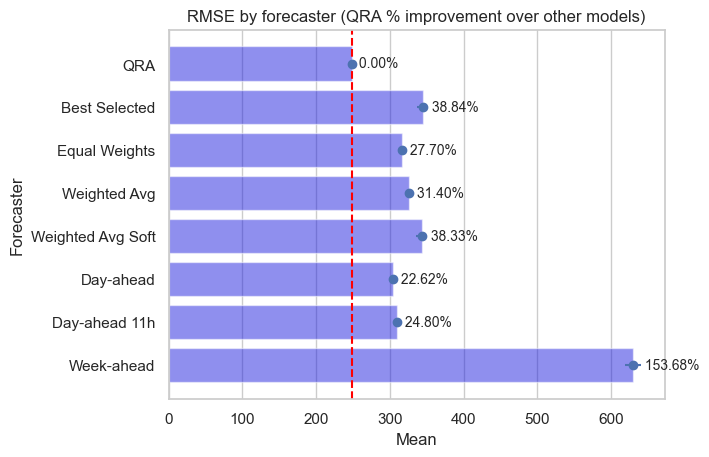

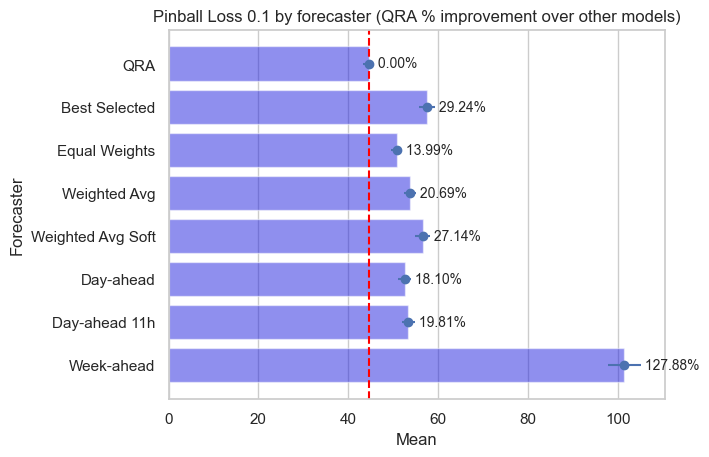

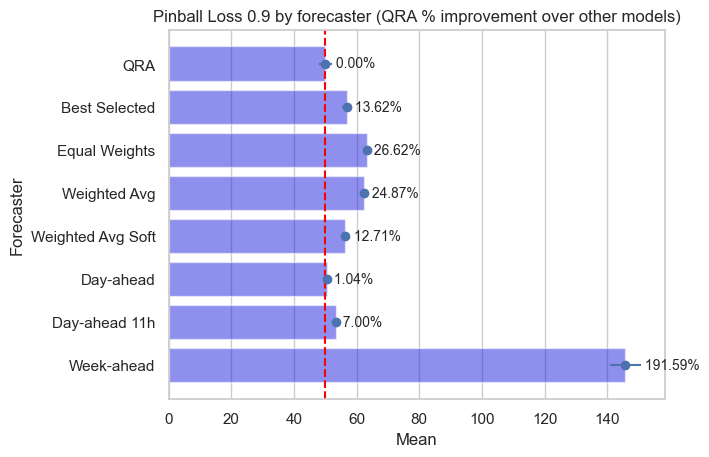

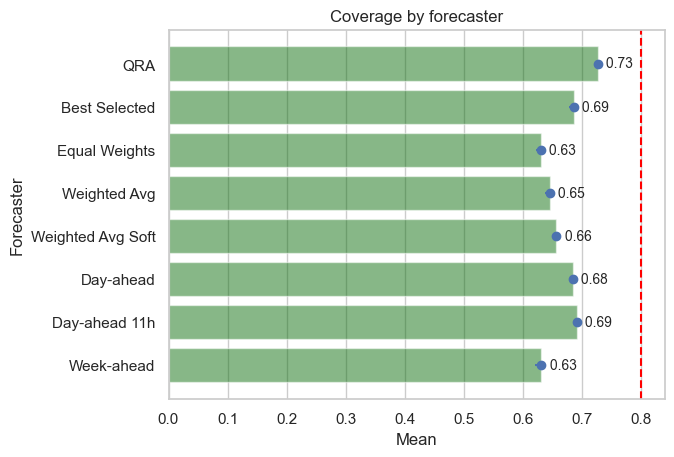

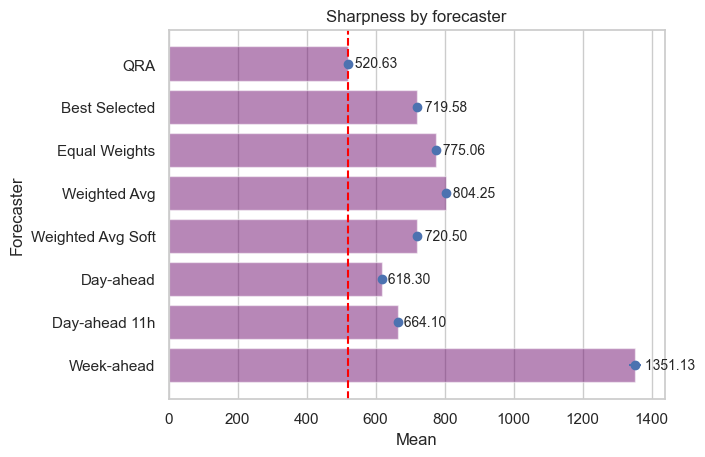

In [26]:
# plot barplot
# rmse
barplot(rmse_list_QRA, rmse_list_dayahead, rmse_list_dayahead11h, rmse_list_weekahead, rmse_list_best, rmse_list_weight_avg, rmse_list_weight_avg_soft, rmse_list_equal_weights, title='RMSE by forecaster')
# pinball loss
barplot(pinball_loss_01_list_QRA, pinball_loss_01_list_dayahead, pinball_loss_01_list_dayahead11h, pinball_loss_01_list_weekahead, pinball_loss_01_list_best, pinball_loss_01_list_weight_avg, pinball_loss_01_list_weight_avg_soft, pinball_loss_01_list_equal_weights, title='Pinball Loss 0.1 by forecaster')
barplot(pinball_loss_09_list_QRA, pinball_loss_09_list_dayahead, pinball_loss_09_list_dayahead11h, pinball_loss_09_list_weekahead, pinball_loss_09_list_best, pinball_loss_09_list_weight_avg, pinball_loss_09_list_weight_avg_soft, pinball_loss_09_list_equal_weights, title='Pinball Loss 0.9 by forecaster')
# percentage of improvement
barplot(coverage_list_QRA, coverage_list_dayahead, coverage_list_dayahead11h, coverage_list_weekahead, coverage_list_best, coverage_list_weight_avg, coverage_list_weight_avg_soft, coverage_list_equal_weights, title='Coverage by forecaster')
# sharpness
barplot(sharpness_list_QRA, sharpness_list_dayahead, sharpness_list_dayahead11h, sharpness_list_weekahead, sharpness_list_best, sharpness_list_weight_avg, sharpness_list_weight_avg_soft, sharpness_list_equal_weights, title='Sharpness by forecaster')

Total number of days: 1089
Total number of years: 3.0
 


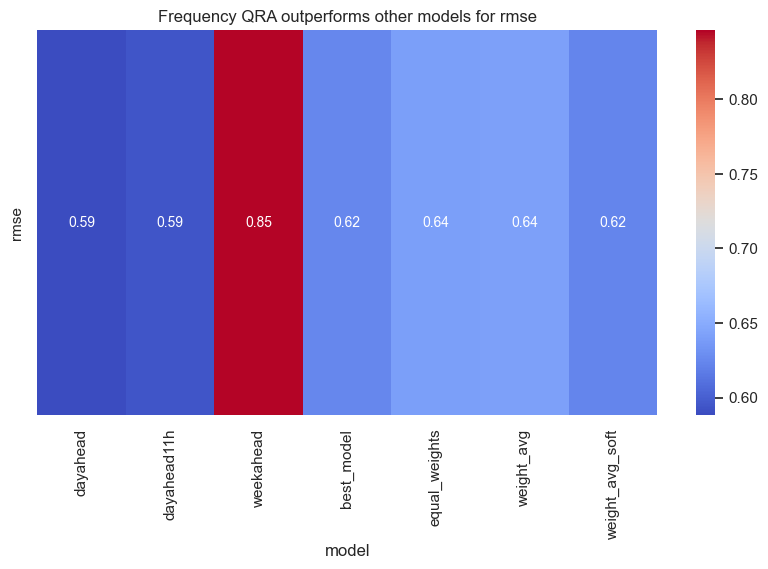

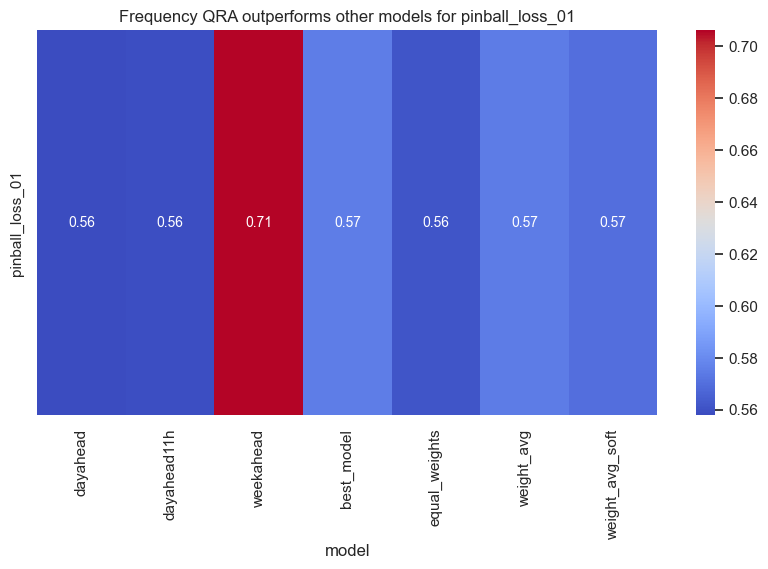

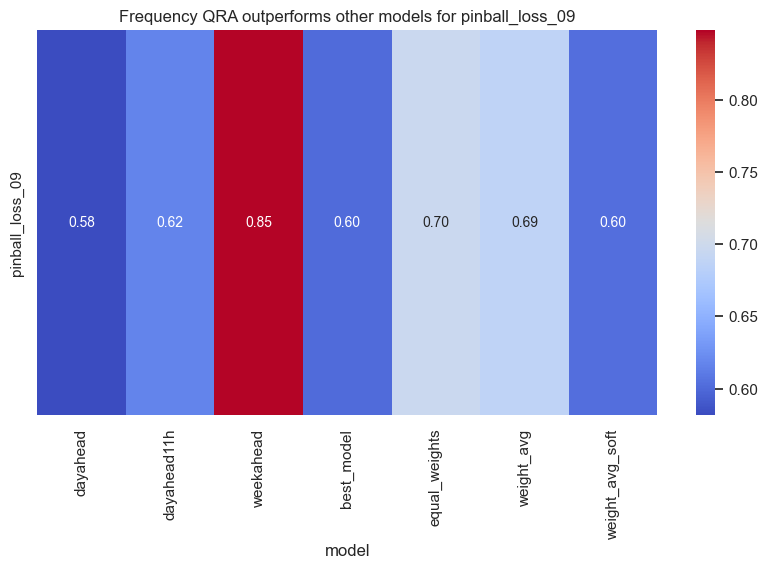

In [27]:
print('Total number of days:', len(rmse_list_QRA))
print('Total number of years:', len(rmse_list_QRA_month_year)/12)
print(' ')

# create dataframe with the frequency results with header 'QRA over model'
df_freq = pd.DataFrame({
    'model': ['dayahead', 'dayahead11h', 'weekahead', 'best_model', 'equal_weights', 'weight_avg', 'weight_avg_soft'],
    'rmse': [sum(list_QRA_over_dayahead)/len(list_QRA_over_dayahead), sum(list_QRA_over_dayahead11h)/len(list_QRA_over_dayahead11h), sum(list_QRA_over_weekahead)/len(list_QRA_over_weekahead), sum(list_QRA_over_best)/len(list_QRA_over_best), sum(list_QRA_over_equal_weights)/len(list_QRA_over_equal_weights), sum(list_QRA_over_weight_avg)/len(list_QRA_over_weight_avg), sum(list_QRA_over_weight_avg_soft)/len(list_QRA_over_weight_avg_soft)],
    'pinball_loss_01': [sum(list_QRA_over_dayahead_01)/len(list_QRA_over_dayahead_01), sum(list_QRA_over_dayahead11h_01)/len(list_QRA_over_dayahead11h_01), sum(list_QRA_over_weekahead_01)/len(list_QRA_over_weekahead_01), sum(list_QRA_over_best_01)/len(list_QRA_over_best_01), sum(list_QRA_over_equal_weights_01)/len(list_QRA_over_equal_weights_01), sum(list_QRA_over_weight_avg_01)/len(list_QRA_over_weight_avg_01), sum(list_QRA_over_weight_avg_soft_01)/len(list_QRA_over_weight_avg_soft_01)],
    'pinball_loss_09': [sum(list_QRA_over_dayahead_09)/len(list_QRA_over_dayahead_09), sum(list_QRA_over_dayahead11h_09)/len(list_QRA_over_dayahead11h_09), sum(list_QRA_over_weekahead_09)/len(list_QRA_over_weekahead_09), sum(list_QRA_over_best_09)/len(list_QRA_over_best_09), sum(list_QRA_over_equal_weights_09)/len(list_QRA_over_equal_weights_09), sum(list_QRA_over_weight_avg_09)/len(list_QRA_over_weight_avg_09), sum(list_QRA_over_weight_avg_soft_09)/len(list_QRA_over_weight_avg_soft_09)]
})
df_freq

# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title):
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.set_index('model').T, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
    plt.title(title)
    # save figure
    plt.savefig(f'{col}_frequency.png', dpi=300, bbox_inches='tight')
    plt.show()

for col in df_freq.columns:
    if col != 'model':
        plot_heatmap(df_freq[['model', col]], title=f'Frequency QRA outperforms other models for {col}')


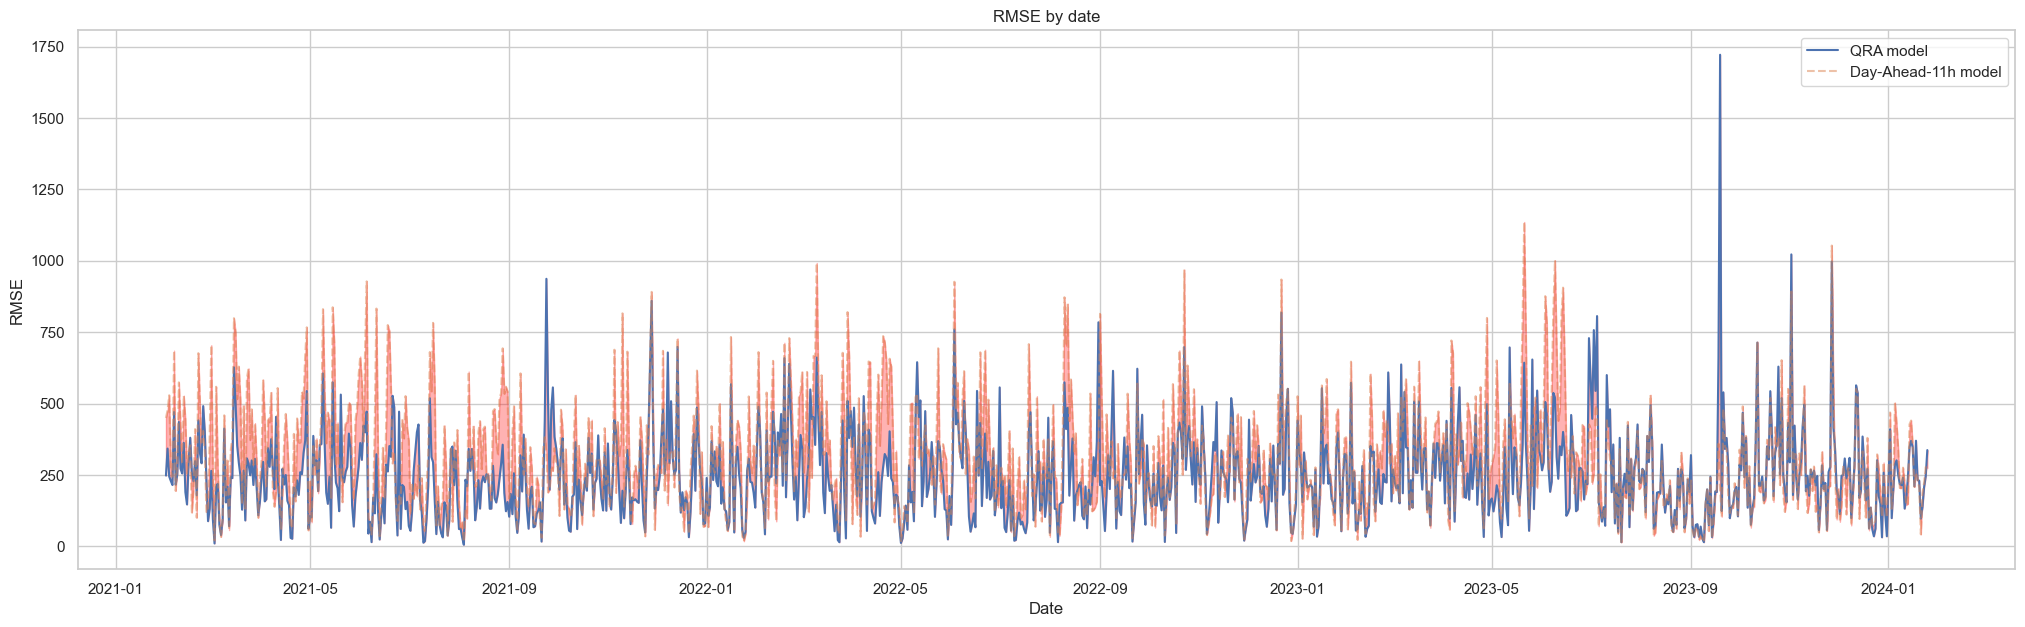

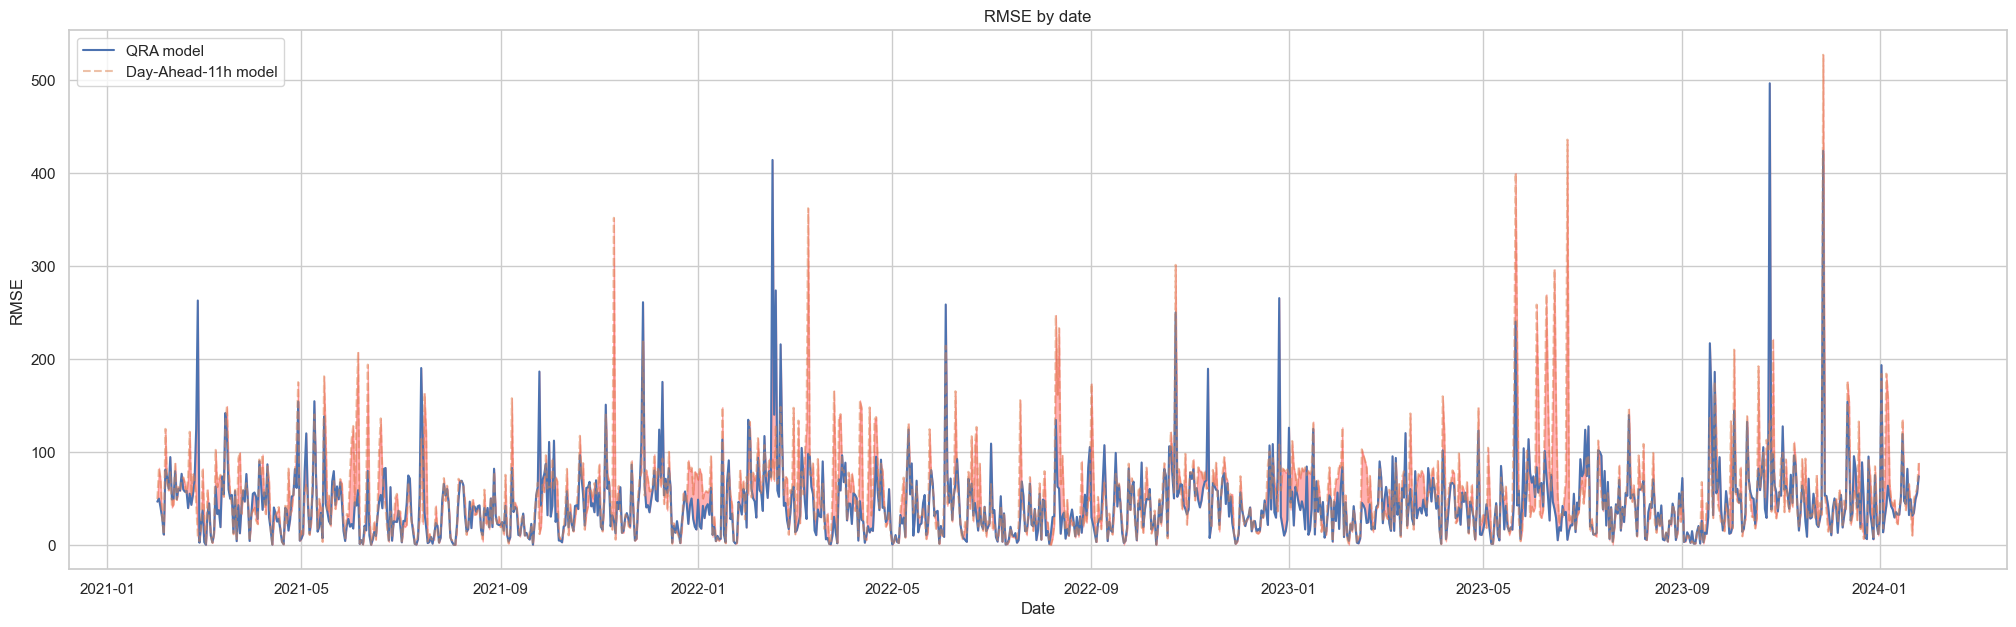

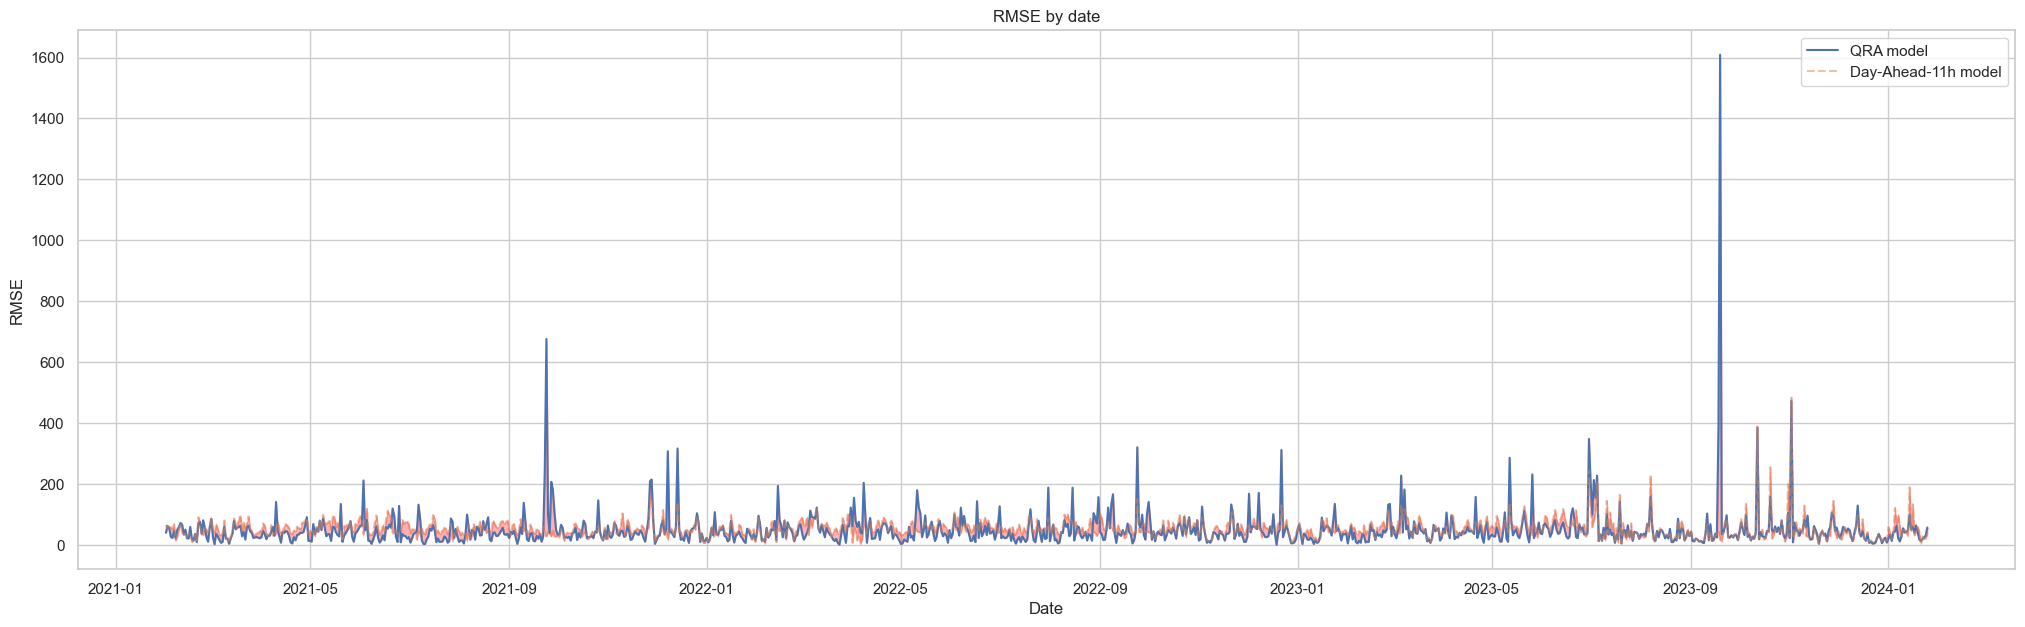

In [13]:
# Date-based analysis
plot_ts_loss(df, rmse_list_QRA, rmse_list_dayahead11h, 'QRA model', 'Day-Ahead-11h model')
plot_ts_loss(df, pinball_loss_01_list_QRA, pinball_loss_01_list_dayahead11h, 'QRA model', 'Day-Ahead-11h model')
plot_ts_loss(df, pinball_loss_09_list_QRA, pinball_loss_09_list_dayahead11h, 'QRA model', 'Day-Ahead-11h model')

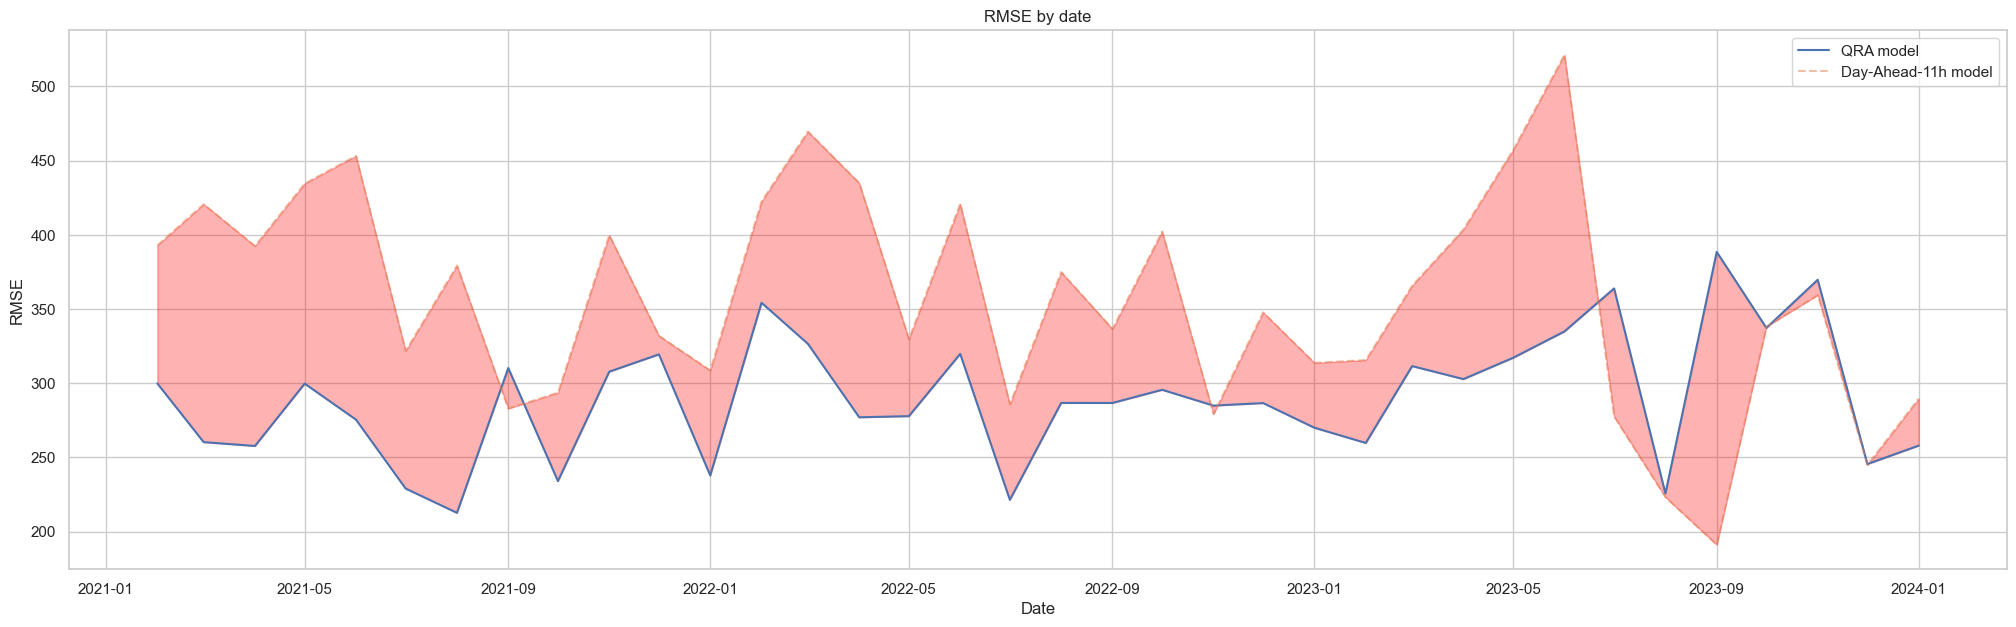

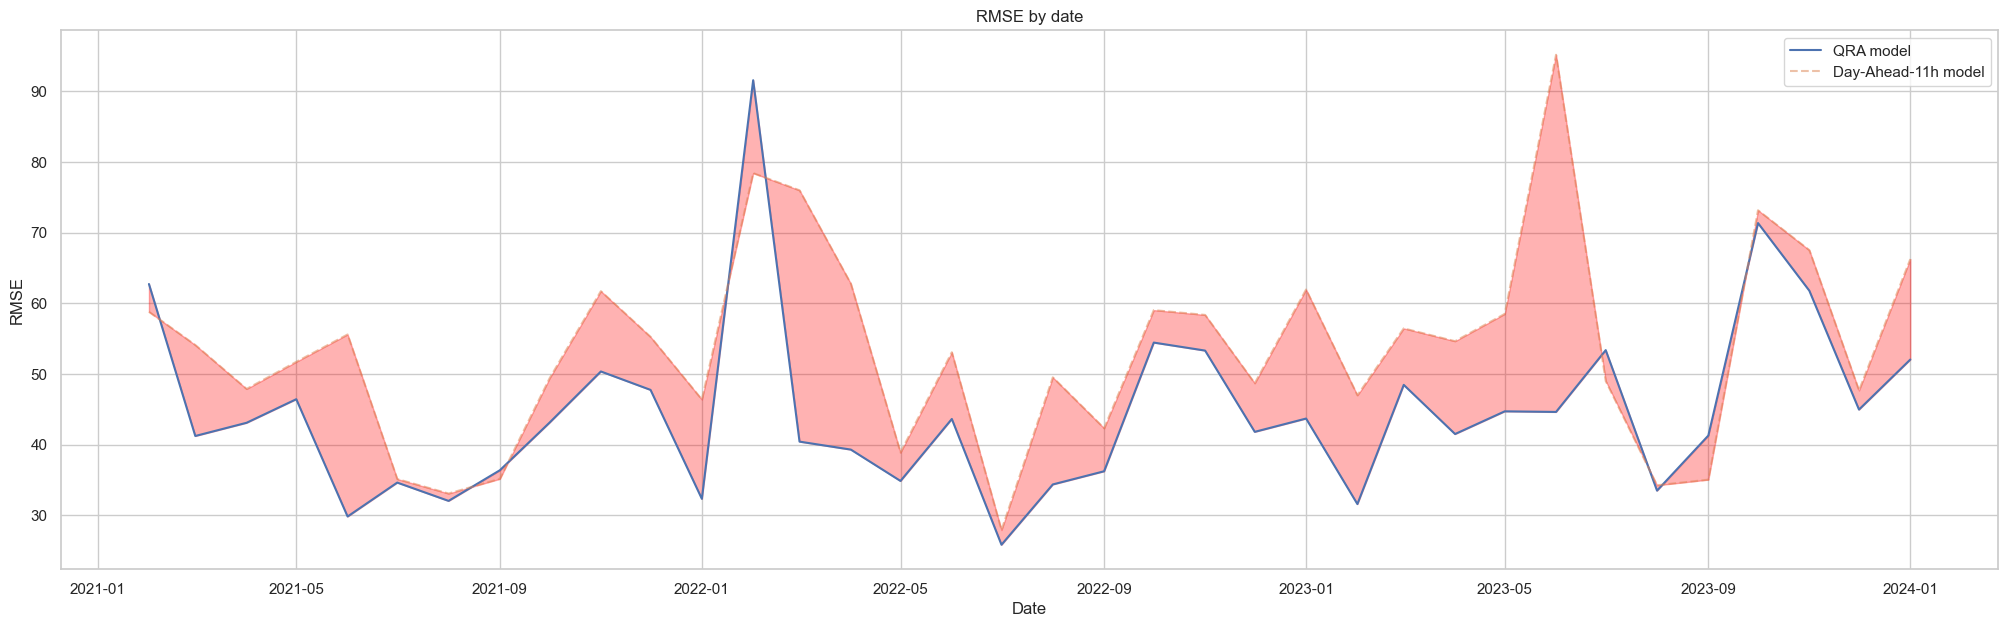

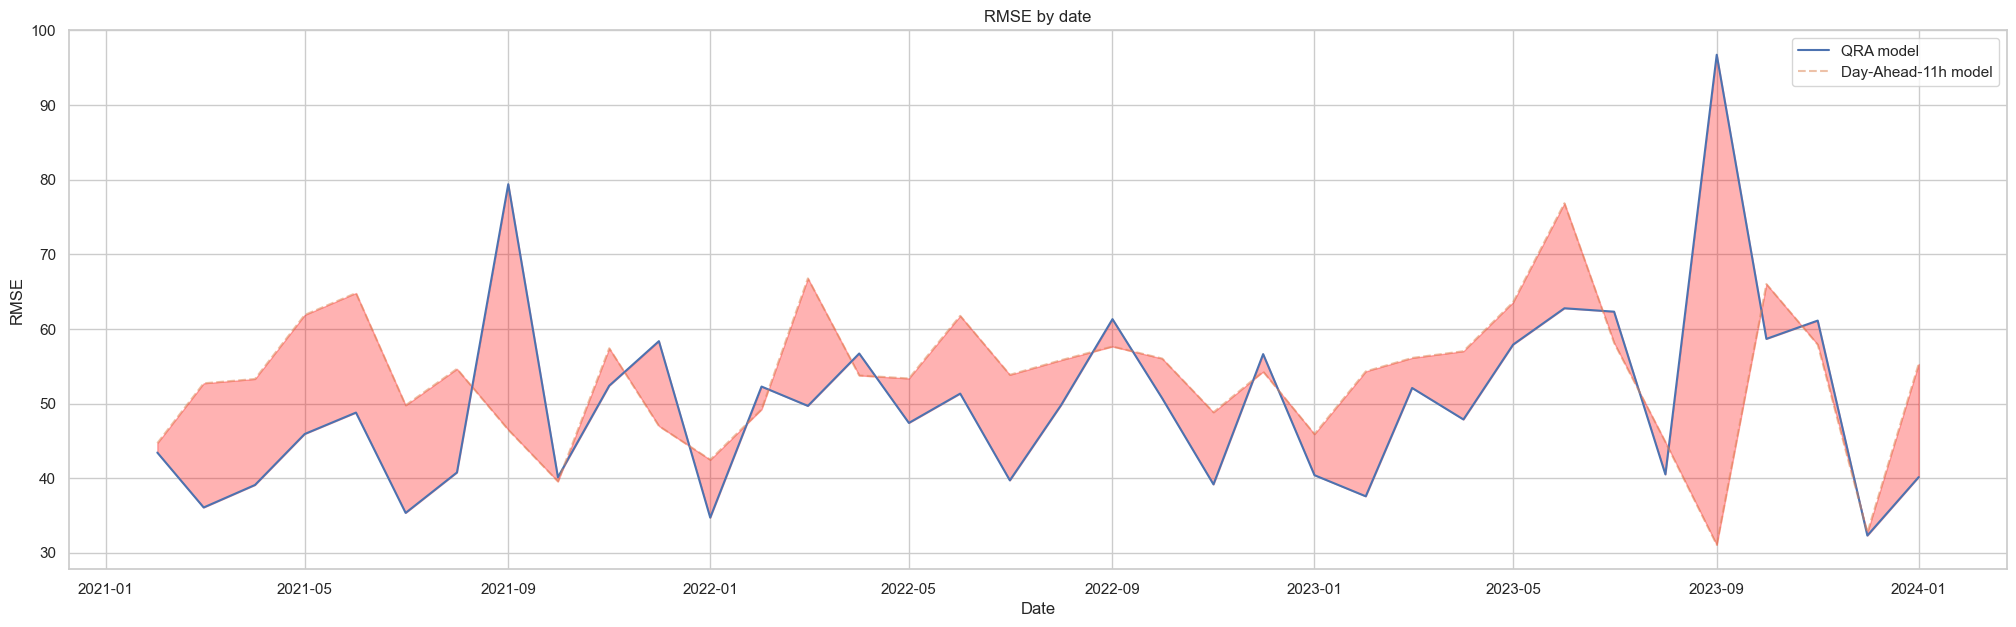

In [14]:
# Monthly-Year-based analysis
plot_ts_loss(df, rmse_list_QRA_month_year, rmse_list_dayahead11h_month_year, 'QRA model', 'Day-Ahead-11h model', date_column='month_year')
plot_ts_loss(df, pinball_loss_01_list_QRA_month_year, pinball_loss_01_list_dayahead11h_month_year, 'QRA model', 'Day-Ahead-11h model', date_column='month_year')
plot_ts_loss(df, pinball_loss_09_list_QRA_month_year, pinball_loss_09_list_dayahead11h_month_year, 'QRA model', 'Day-Ahead-11h model', date_column='month_year')

In [15]:
import scikit_posthocs as sp

def statistical_hypothesis_testing(loss_list_QRA, loss_list_dayahead, loss_list_dayahead11h, loss_list_weekahead, loss_best_model, loss_weight_avg, loss_weight_avg_soft, loss_equal_weights, title):
    """ Perform statistical hypothesis testing using the Friedman test and posthoc Nemenyi test 
    """
    # Construct the dictionary from the input lists
    dict_data = {
        'QRA': loss_list_QRA,
        'dayahead': loss_list_dayahead,
        'dayahead11h': loss_list_dayahead11h,
        'weekahead': loss_list_weekahead,
        'selection': loss_best_model,
        'weight_avg': loss_weight_avg,
        'weight_avg_soft': loss_weight_avg_soft,
        'weight_equal': loss_equal_weights
    }
    # Transform the dictionary into a DataFrame
    data = (
        pd.DataFrame(dict_data)
        .rename_axis('days')  # Set the index name to 'days'
        .melt(                # Melt the DataFrame to long format
            var_name='model',
            value_name='loss',
            ignore_index=False,
        )
        .reset_index()        # Reset the index to include 'days' as a column
    )
    # Perform posthoc Nemenyi Friedman test
    tests_results = sp.posthoc_nemenyi_friedman(data, y_col='loss', group_col='model', block_col='days',  block_id_col='days', melted=True) #
    # Define the colormap and heatmap arguments
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {
        'cmap': cmap,
        'linewidths': 0.25,
        'linecolor': '0.5',
        'clip_on': False,
        'square': True,
        'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]
    }
    
    # Compute the average rank of each model
    print('------------------------------------')
    avg_rank = data.groupby('days').loss.rank(method='average').groupby(data.model).mean()
    print(f"Average rank of the models - {avg_rank}")

    # Plot the heatmap
    plt.title(f"P-values posthoc Nemenyi test for {title}")
    # mask the upper triangle
    mask = np.triu(np.ones_like(tests_results, dtype=bool))
    tests_results_masked = tests_results.mask(mask)
    # print the p-values
    # add to column names the avg rank in square brackets
    # in bold if QRA
    tests_results_masked.columns = [f"{col} - {avg_rank[col]:.3f}" for col in tests_results_masked.columns]
    tests_results_masked.columns = [f"**{col}**" if 'QRA' in col else col for col in tests_results_masked.columns]
    tests_results_masked.index = [f"{col} - {avg_rank[col]:.3f}" for col in tests_results_masked.index]
    tests_results_masked.index = [f"**{col}**" if 'QRA' in col else col for col in tests_results_masked.index]
    # add header
    tests_results_masked.columns.name = 'Average Rank of the models'
    tests_results_masked.index.name = 'Average Rank of the models'

    # figure size
    sp.sign_plot(tests_results_masked, **heatmap_args)
    # save image
    # split the title
    title = title.replace(' ', '_')
    plt.savefig(f'p_values_posthoc_nemenyi_test_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()


    


------------------------------------
Average rank of the models - model
QRA                2.895317
dayahead           4.025712
dayahead11h        4.345271
selection          4.540863
weekahead          6.955005
weight_avg         4.580349
weight_avg_soft    4.332415
weight_equal       4.325069
Name: loss, dtype: float64


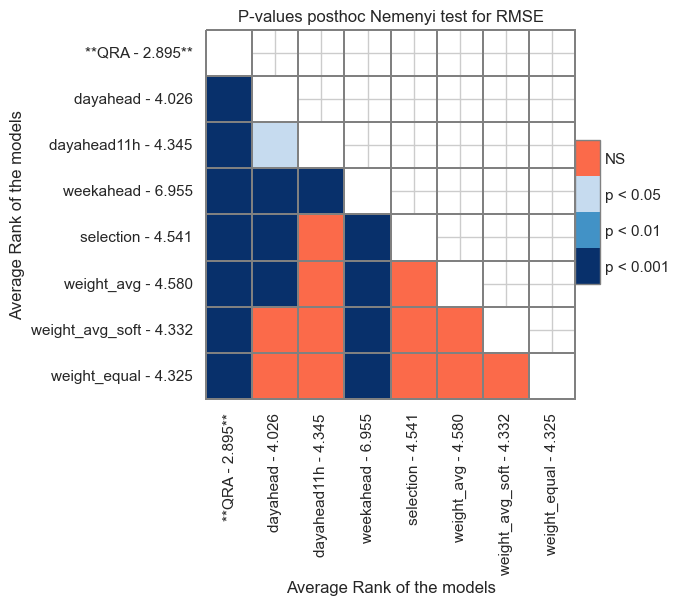

------------------------------------
Average rank of the models - model
QRA                3.682736
dayahead           4.179522
dayahead11h        4.179522
selection          4.543618
weekahead          6.702479
weight_avg         4.618916
weight_avg_soft    4.158402
weight_equal       3.934803
Name: loss, dtype: float64


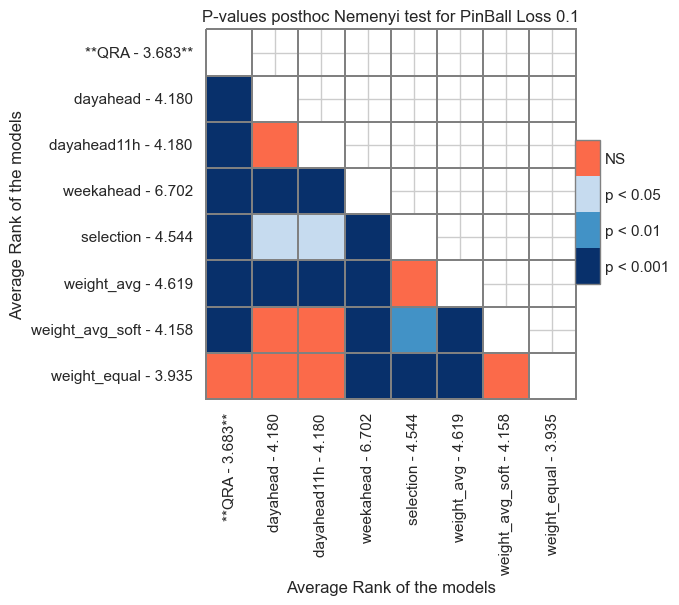

------------------------------------
Average rank of the models - model
QRA                2.925620
dayahead           4.229568
dayahead11h        4.229568
selection          3.440312
weekahead          7.327824
weight_avg         5.357208
weight_avg_soft    3.485767
weight_equal       5.004132
Name: loss, dtype: float64


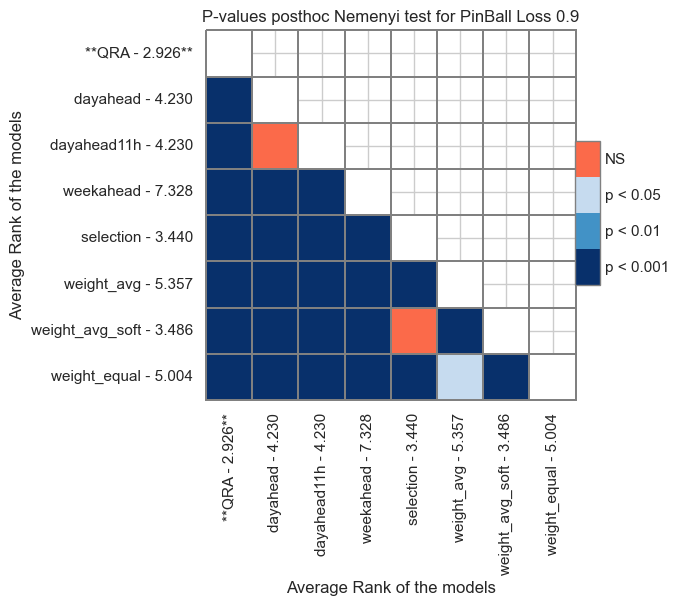

In [16]:
# rmse
statistical_hypothesis_testing(rmse_list_QRA, rmse_list_dayahead, rmse_list_dayahead11h, rmse_list_weekahead, rmse_list_best, rmse_list_weight_avg, rmse_list_weight_avg_soft, rmse_list_equal_weights, title='RMSE')
# pinball loss tau = 0.1
data_q10 = statistical_hypothesis_testing(pinball_loss_01_list_QRA, pinball_loss_01_list_dayahead11h, pinball_loss_01_list_dayahead11h, pinball_loss_01_list_weekahead, pinball_loss_01_list_best, pinball_loss_01_list_weight_avg, pinball_loss_01_list_weight_avg_soft, pinball_loss_01_list_equal_weights, title='PinBall Loss 0.1')
# pinball loss tau = 0.9
data_q90 = statistical_hypothesis_testing(pinball_loss_09_list_QRA, pinball_loss_09_list_dayahead11h, pinball_loss_09_list_dayahead11h, pinball_loss_09_list_weekahead, pinball_loss_09_list_best, pinball_loss_09_list_weight_avg, pinball_loss_09_list_weight_avg_soft, pinball_loss_09_list_equal_weights, title='PinBall Loss 0.9')